In [1]:
import numpy as np
import xarray as xr
import pandas as pd
from salishsea_tools import viz_tools, places, visualisations
from matplotlib import pyplot as plt, dates
from datetime import datetime, timedelta
from calendar import month_name
from scipy.io import loadmat
from tqdm.notebook import tqdm
from salishsea_tools import nc_tools
from dask.diagnostics import ProgressBar
import cmocean
import arrow
import glob
import re
from datetime import datetime

%matplotlib inline

In [2]:
plt.rcParams.update({'font.size': 12, 'axes.titlesize': 'medium'})

### Goal is to check the control run for ocean acidification project (present day scenario) and compare to v202111 to see if the phytoplankton match up.

#### Comparison of Diatoms between OA control run and v202111

In [3]:
def load_daily_biomass(file_pattern, label):
    files = sorted(glob.glob(file_pattern))
    print(f"[{label}] Found {len(files)} files")

    # Load mask info
    mask = xr.open_dataset('/ocean/ksuchy/MOAD/NEMO-forcing/grid/mesh_mask202108.nc')
    slc = {'y': slice(450, 500), 'x': slice(250, 300)}
    e3t, tmask = [mask[var].isel(z=slice(None, 27), **slc).values for var in ('e3t_0', 'tmask')]

    dates, biomass = [], []

    for file in files:
        match = re.search(r'SalishSea_1d_(\d{8})_', file)
        if not match:
            continue
        date_str = match.group(1)
        date = datetime.strptime(date_str, "%Y%m%d")

        try:
            with xr.open_dataset(file) as ds:
                diatoms = ds['diatoms'].isel(deptht=slice(None, 27), **slc).values
                integrated = np.ma.masked_where(tmask == 0, diatoms * e3t).sum(axis=1).data
                daily_mean = integrated[0].mean()

                dates.append(date)
                biomass.append(daily_mean)
        except Exception as e:
            print(f"[{label}] Error processing {file}: {e}")

    return pd.DataFrame({'Date': dates, label: biomass}).sort_values('Date')

# Define file patterns for both runs
file_pattern_A = '/data/sallen/results/MEOPAR/Karyn/Carbon_v202111/Present_Lb80/*/SalishSea_1d_2011*_2011*_ptrc_T.nc'
file_pattern_B = '/results2/SalishSea/nowcast-green.202111/*/SalishSea_1d_2011*_2011*_biol_T.nc'

# Load both datasets
df_A = load_daily_biomass(file_pattern_A, 'Control')
df_B = load_daily_biomass(file_pattern_B, 'v202111')

# Merge on Date to align
df_merged = pd.merge(df_A, df_B, on='Date', how='inner')



[Control] Found 182 files
[v202111] Found 365 files


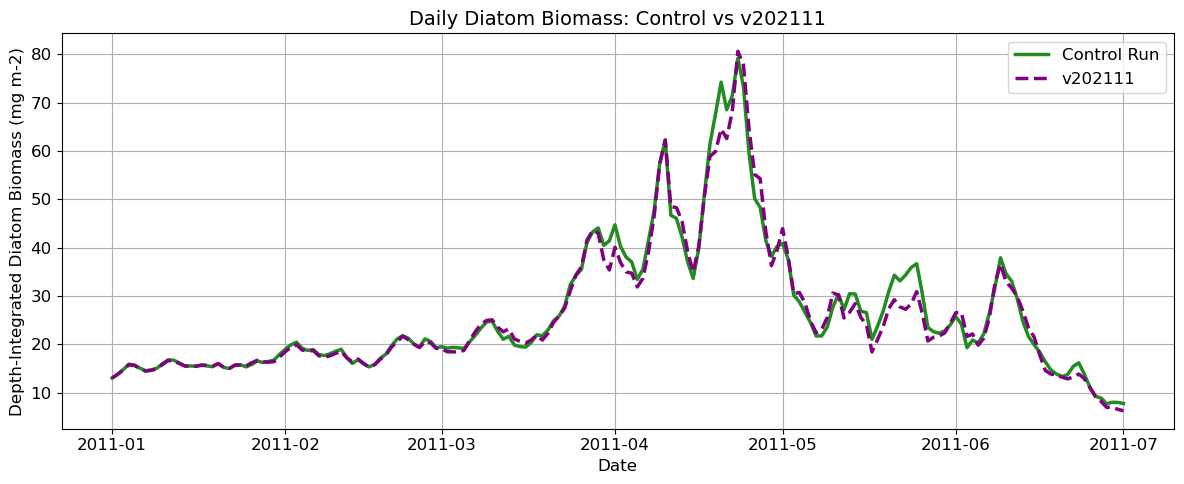

In [4]:
# Plot
plt.figure(figsize=(12, 5))
plt.plot(df_merged['Date'], df_merged['Control'], label='Control Run', linewidth=2.5,linestyle='-',color='forestgreen')
plt.plot(df_merged['Date'], df_merged['v202111'], label='v202111', linewidth=2.5,linestyle='--',color='purple')
plt.title("Daily Diatom Biomass: Control vs v202111", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Depth-Integrated Diatom Biomass (mg m-2)", fontsize=12)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()